In [2]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [10]:
class NeuronModel:
    """Class containing attributes and methods for the sand-pile model.
    """
    def __init__(self, network, sample_delay=200) -> None:
        # Network should have a node with the label -1 which is the sink node
        # All nodes should be able to reach the sink node
        self.network = network

        assert network.has_node(-1), "Network must contain sink node (label -1)"
        assert nx.ancestors(network, -1) == set(network.nodes).difference({-1,}), "All nodes must be able to reach the sink node"

        self.size = network.number_of_nodes() - 1  # Without the sink node

        self.adj_matrix = nx.adjacency_matrix(self.network, nodelist=[-1] + list(network.nodes)[:-1]).toarray()
        self.potentials = np.zeros(self.adj_matrix.shape[0])
        self.degrees = np.array([np.sum(self.adj_matrix[i]) for i in range(self.adj_matrix.shape[0])])

        self.sample_delay = sample_delay

        # Data storage
        self.avalanche_sizes = []

    def get_node_degree(self, node_i):
        return np.sum(self.adj_matrix[node_i])

    def topple_node(self, node_i):
        new_potentials = np.copy(self.potentials)

        # Decrease potential of toppled node
        new_potentials[node_i] -= self.get_node_degree(node_i)

        # Add one unit of potential to each neighbor
        new_potentials[self.adj_matrix[node_i].astype(bool)] += 1

        self.potentials = new_potentials

    def perform_avalanche(self, start_node):
        unstable = np.array([start_node])
        curr_node = None
        avalanche_size = 0

        while unstable.size > 0:
            # Pick a random unstable node
            random_index = np.random.randint(0, len(unstable))
            curr_node = unstable[random_index]

            # Topple unstable node
            self.topple_node(curr_node)
            avalanche_size += 1

            unstable = np.arange(self.potentials.size)[self.potentials >= self.degrees][1:]

        return avalanche_size

    def step(self, iteration) -> None:
        # Choose random node (ignore node 0 (sink node))
        node_i = np.random.randint(1, self.size + 1)

        # Increment potential
        self.potentials[node_i] += 1

        # Check for instabilities
        if self.potentials[node_i] >= self.get_node_degree(node_i):
            avalanche_size = self.perform_avalanche(node_i)

            if iteration > self.sample_delay:
                self.avalanche_sizes.append(avalanche_size)

    def run(self, n_steps):
        assert self.sample_delay < n_steps, "Number of steps must be higher than sample delay"

        for i in range(n_steps):
            self.step(i)

        return np.array(self.avalanche_sizes)


In [11]:
def create_2d_grid_graph(rows, columns):
    """Returns network as 2D grid graph and nodes on the periphery are connected to sink"""
    grid_graph = nx.grid_2d_graph(rows, columns)
    converted_graph = nx.convert_node_labels_to_integers(grid_graph)
    converted_graph.add_node(-1)  # Add sink node

    for node in converted_graph.nodes():
        if converted_graph.degree(node) < 4:
            converted_graph.add_edge(node, -1)  # Add edge to sink node

    return converted_graph

In [15]:
rows = 10
columns = 10

grid_network = create_2d_grid_graph(rows, columns)
grid_network_model = NeuronModel(grid_network)   
grid_network_data = np.array(grid_network_model.run(100000))  # number of steps

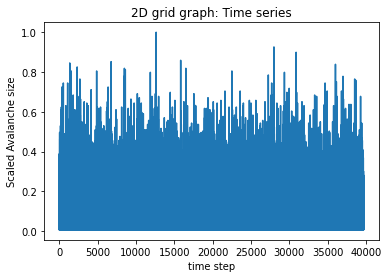

In [16]:
norm_grid_network_data = [aval_size/max(grid_network_data) for aval_size in grid_network_data] #to scale data

plt.figure()
plt.plot(norm_grid_network_data)

# Add labels and title
plt.xlabel('time step')
plt.ylabel('Scaled Avalanche size')
plt.title('2D grid graph: Time series')

# Show the plot
plt.show()   

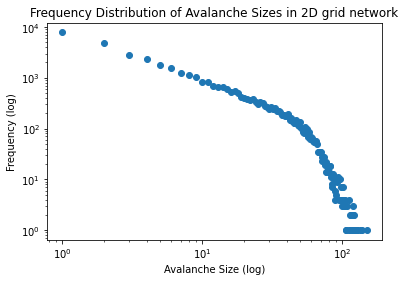

In [17]:
# Calculate the unique avalanche sizes and their frequencies
avalanche_sizes_grid, frequencies_grid = np.unique(grid_network_data, return_counts=True)

# Plot the data points on a log-log scale
plt.figure()
plt.scatter(avalanche_sizes_grid, frequencies_grid)

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Avalanche Size (log)')
plt.ylabel('Frequency (log)')
plt.title('Frequency Distribution of Avalanche Sizes in 2D grid network')

# Show the plot
plt.show()